# Generate predictions.out & probabilities.out

In [ ]:
FIX_OUTPUT_BUG = False # If the first word is in the last position of the sentence in the .XLSX then FIX_OUTPUT_BUG must be True
FILE_PATH = '/content/drive/MyDrive/TFG/SimpleHTR/SIM_BeamSearch/' # SIM_BestPath  or  SIM_BeamSearch  or  SIM_WordBeamSearch

In [ ]:
from openpyxl import Workbook
from openpyxl import load_workbook
from tqdm import tqdm

wb = load_workbook(filename = FILE_PATH + 'inferOutput.xlsx')

fs = open(FILE_PATH + "predictions.out", "w")
fp = open(FILE_PATH + "probabilities.out", "w")

for wsn in tqdm(wb.sheetnames):
    if wsn != 'Sheet' and wsn != 'Sheet1' and wsn[-5:] != '_prob':  #Skip first 2 empty pages and all _prob pages.
        ws = wb[wsn]           # Predictions sheet
        wp = wb[wsn + "_prob"] # Probabilities sheet corresponding to the predictions
        
        # Build each sentence
        s1 = ""
        s2 = ""
        s3 = ""
        s4 = ""
        s5 = ""
        # Probability for each sentence
        p1 = float(wp['A1'].value)
        p2 = float(wp['B1'].value)
        p3 = float(wp['C1'].value)
        p4 = float(wp['D1'].value)
        p5 = float(wp['E1'].value)
        r = 1 # Row number to traverse the whole sheet
        while ws['A' + str(r)].value != None:
            if FIX_OUTPUT_BUG and ws['A' + str(r+1)].value == None:
              s1 = ws['A' + str(r)].value + " " + s1
              s2 = ws['B' + str(r)].value + " " + s2
              s3 = ws['C' + str(r)].value + " " + s3
              s4 = ws['D' + str(r)].value + " " + s4
              s5 = ws['E' + str(r)].value + " " + s5
            else:
              s1 += " " + ws['A' + str(r)].value
              s2 += " " + ws['B' + str(r)].value
              s3 += " " + ws['C' + str(r)].value
              s4 += " " + ws['D' + str(r)].value
              s5 += " " + ws['E' + str(r)].value
            p1 += float(wp['A' + str(r)].value)
            p2 += float(wp['B' + str(r)].value)
            p3 += float(wp['C' + str(r)].value)
            p4 += float(wp['D' + str(r)].value)
            p5 += float(wp['E' + str(r)].value)

            r += 1
        
        # AVG(probability)
        p1 = p1 / r
        p2 = p2 / r
        p3 = p3 / r
        p4 = p4 / r
        p5 = p5 / r


        idx = wsn[4:]

        fs.write("### Sentence " + idx + "\n")
        fp.write("### Sentence " + idx + "\n")

        fs.write(s1 + "\n")
        fs.write(s2 + "\n")
        fs.write(s3 + "\n")
        fs.write(s4 + "\n")
        fs.write(s5 + "\n")
        fp.write(str(p1) + "\n")
        fp.write(str(p2) + "\n")
        fp.write(str(p3) + "\n")
        fp.write(str(p4) + "\n")
        fp.write(str(p5) + "\n")

fs.close()
fp.close()

100%|██████████| 893/893 [00:01<00:00, 850.51it/s]


# Define FILE_PATHS

In [3]:
FILE_PATHS = [# SimpleHTR default training
              "/content/drive/MyDrive/TFG/SimpleHTR/SIM_BestPath/"
              ,"/content/drive/MyDrive/TFG/SimpleHTR/SIM_BeamSearch/"
              ,"/content/drive/MyDrive/TFG/SimpleHTR/SIM_WordBeamSearch/"

              # SimpleHTR default training with spellingcorrector
              ,"/content/drive/MyDrive/TFG/SimpleHTR/SIM_BestPath/spellingcorrector/"
              ,"/content/drive/MyDrive/TFG/SimpleHTR/SIM_BeamSearch/spellingcorrector/"
              ,"/content/drive/MyDrive/TFG/SimpleHTR/SIM_WordBeamSearch/spellingcorrector/"


              # SimpleHTR SQL training
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_BestPath/"
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_BeamSearch/"
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_WordBeamSearch/"

              # SimpleHTR SQL training with spellingcorrector
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_BestPath/spellingcorrector/"
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_BeamSearch/spellingcorrector/"
              ,"/content/drive/MyDrive/TFG/TrainSimpleHTR/SIM_WordBeamSearch/spellingcorrector/"


              # MXNet Gluon default training
              ,"/content/drive/MyDrive/TFG/MXNetGluon/results/"

              # MXNet Gluon default training with spellingcorrector
              ,"/content/drive/MyDrive/TFG/MXNetGluon/results/spellingcorrector/"
              ]

# Analyze predictions with Jellyfish

In [ ]:
!pip install jellyfish

In [ ]:
import jellyfish as jf
import matplotlib.pyplot as plt
from statistics import mean
import random

with open("/content/drive/MyDrive/TFG/HTG/input/PerfectSQL_2.sql", "r") as fo:
  # Store original lines
  original_lines = fo.readlines()
  for FILE_PATH in FILE_PATHS:
    if FILE_PATH.split('/')[-2] == 'spellingcorrector':
      FILENAME = FILE_PATH + "predictions_fixed_SQL.out"
    else:
      FILENAME = FILE_PATH + "predictions.out"
    with open(FILENAME, "r") as fs: # _fixed_SQL
      prt = FILE_PATH.split('/')
      print('\n' + "Analyzing " + prt[len(prt)-3] + ' --> ' + prt[len(prt)-2])
      
      lines = fs.readlines()
      n_sentences = len(lines) // 6 # There are 6 lines per sentence (1 with the number of sentence and 5 handwriting styles)
      sentences = [["" for _ in range(5)] for _ in range(n_sentences)]

      n = -1
      i = 0
      for line in lines:
          if line[0:4] == '### ': # Sentence number
              ls = line.split()
              n = int(ls[len(ls)-1])
              i = 0
          else:
              sentences[n][i] = line[:-1]
              i+=1

      #Levenshtein Distance
      # levenshtein_distance(s1, s2)
      ld = [] #levenshtein distances
      ldx = [] #tags for matplotlib
      lens = [] #length of sentence
      with open(FILE_PATH + "levenshtein_distance.out", "w") as fld:
        for i in range(len(original_lines)):
            for j in range(5):
                ldi = jf.levenshtein_distance(sentences[i][j].upper().lstrip(), original_lines[i].upper().lstrip()) - 2 # -2 to compensate random characters that obfuscate the result

                lens.append(len(original_lines[i]))
                ld.append(ldi)
                ldx.append("s" + str(i) + "_" + str(j+1))
                fld.write(str(ldi) + "\n")

      # print("LEVENSHTEIN Distance MEAN:     ", round(mean(ld), 2), "MIN:", min(ld), "MAX:", max(ld))
      # print("Original sentences MEAN LENGTH:", round(mean(lens), 2), "MIN:", min(lens), "MAX:", max(lens))

      
      # plt.bar(ldx, ld, width=0.2)
      # fig = plt.gcf()
      # fig.set_size_inches(910, 10, forward=True)
      # plt.show()


      #Levenshtein Ratio
      with open(FILE_PATH + "levenshtein_ratio.out", "w") as flr:
        LR = []
        for i in range(len(ld)):
          lr = ld[i]/lens[i]
          LR.append(lr)
          flr.write(str(lr) + "\n")

      # Plot some charts of random sentences
      plt_tags = []
      plt_vals = []
      for i in range(5):
        n = random.randint(0,len(ldx)-1)
        plt_tags.append(ldx[n])
        plt_vals.append(LR[n])
      # plt.bar(plt_tags, plt_vals)
      # plt.show()

      print("LEVENSHTEIN RATIO AVG: ", mean(LR))
  


#Damerau-Levenshtein Distance
# damerau_levenshtein_distance(s1, s2)

#Hamming Distance
# hamming_distance(s1, s2)

#Jaro Similarity
# jaro_similarity(s1, s2)

#Jaro-Winkler Similarity
# jaro_winkler_similarity(s1, s2)

#Match Rating Approach (comparison)
# match_rating_comparison(s1, s2)


Analyzing SimpleHTR --> SIM_BestPath
LEVENSHTEIN RATIO AVG:  0.162108048232781

Analyzing SimpleHTR --> SIM_BeamSearch
LEVENSHTEIN RATIO AVG:  0.15848512887821947

Analyzing SimpleHTR --> SIM_WordBeamSearch
LEVENSHTEIN RATIO AVG:  0.4445209080990918

Analyzing SIM_BestPath --> spellingcorrector
LEVENSHTEIN RATIO AVG:  0.16266337713950058

Analyzing SIM_BeamSearch --> spellingcorrector
LEVENSHTEIN RATIO AVG:  0.15939409659903317

Analyzing SIM_WordBeamSearch --> spellingcorrector
LEVENSHTEIN RATIO AVG:  0.4421525574480012

Analyzing TrainSimpleHTR --> SIM_BestPath
LEVENSHTEIN RATIO AVG:  0.008392901973883374

Analyzing TrainSimpleHTR --> SIM_BeamSearch
LEVENSHTEIN RATIO AVG:  0.008166550492181941

Analyzing TrainSimpleHTR --> SIM_WordBeamSearch
LEVENSHTEIN RATIO AVG:  0.004165952794052635

Analyzing SIM_BestPath --> spellingcorrector
LEVENSHTEIN RATIO AVG:  0.03746934351554459

Analyzing SIM_BeamSearch --> spellingcorrector
LEVENSHTEIN RATIO AVG:  0.03724892020478507

Analyzing SIM_Wor

# Generate plot for random sentences

BestPath --> 80_2 --> 0.17142857142857143
BestPath --> 288_4 --> 0.17898832684824903
BestPath --> 97_2 --> 0.17857142857142858
BestPath --> 59_2 --> 0.17266187050359713
BestPath --> 426_2 --> 0.17793594306049823
BeamSearch --> 80_2 --> 0.17551020408163265
BeamSearch --> 288_4 --> 0.17509727626459143
BeamSearch --> 97_2 --> 0.15873015873015872
BeamSearch --> 59_2 --> 0.17266187050359713
BeamSearch --> 426_2 --> 0.1708185053380783
WordBeamSearch --> 80_2 --> 0.44081632653061226
WordBeamSearch --> 288_4 --> 0.44357976653696496
WordBeamSearch --> 97_2 --> 0.48412698412698413
WordBeamSearch --> 59_2 --> 0.4460431654676259
WordBeamSearch --> 426_2 --> 0.5587188612099644


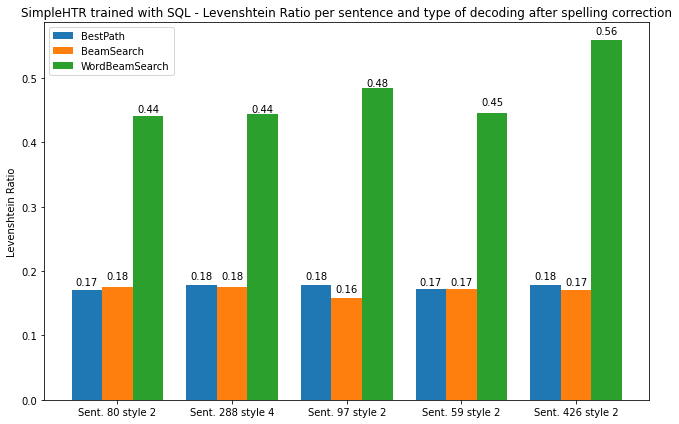

[[0.17142857142857143, 0.17898832684824903, 0.17857142857142858, 0.17266187050359713, 0.17793594306049823], [0.17551020408163265, 0.17509727626459143, 0.15873015873015872, 0.17266187050359713, 0.1708185053380783], [0.44081632653061226, 0.44357976653696496, 0.48412698412698413, 0.4460431654676259, 0.5587188612099644]]
['s80_2', 's288_4', 's97_2', 's59_2', 's426_2']


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
prop = 5 # Number of handwriting styles per sentence
NUM_PLOTS = 5
fixed_settings = True

plt_tags = []
plt_vals = []
with open("/content/drive/MyDrive/TFG/HTG/input/PerfectSQL_2.sql", "r") as fo:
  original_lines = fo.readlines()

  # Pick random sentences and handwritting styles for each of them
  ids = [80, 288, 97, 59, 426]
  hws = [2, 4, 2, 2, 2]
  if fixed_settings == False:
    ids = []
    hws = []
    for _ in range(NUM_PLOTS):
      ids.append(random.randint(0,len(original_lines)-1))
      hws.append(random.randint(0,prop-1))

  # Get the sentence for each file
  for FILE_PATH in FILE_PATHS:
    with open(FILE_PATH + "levenshtein_ratio.out", "r") as FLR:
      LR = FLR.readlines()
      cur_vals = []
      for i in range(len(ids)):
        cur_vals.append(float(LR[ ids[i]*prop + hws[i] ][:-1])) # Get the sentence with the respective handwriting style
        print(FILE_PATH.split('/')[-2:][0][4:] + " --> " + str(ids[i]) + "_" + str(hws[i]) + " --> " + LR[ ids[i]*prop + hws[i] ][:-1])
        if ("s" + str(ids[i]) + "_" + str(hws[i])) not in plt_tags:
          plt_tags.append("s" + str(ids[i]) + "_" + str(hws[i]))
      plt_vals.append(cur_vals)
      # plt_tags.append("s" + str(ids[i]) + "_" + str(hws[i]) + " " + FILE_PATH.split('/')[-2:][0][4:])

# Plot the results
x = np.arange(len(plt_tags)) # the label locations
width = 0.8 # the witdh of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, plt_vals[0], width/3, label=FILE_PATHS[0].split('/')[-2:][0][4:])
rects2 = ax.bar(x,         plt_vals[1], width/3, label=FILE_PATHS[1].split('/')[-2:][0][4:])
rects3 = ax.bar(x + width/3, plt_vals[2], width/3, label=FILE_PATHS[2].split('/')[-2:][0][4:])

ax.set_ylabel('Levenshtein Ratio')
ax.set_title('SimpleHTR trained with SQL - Levenshtein Ratio per sentence and type of decoding after spelling correction')
ax.set_xticks(x)
xlabs = []
for i in range(len(ids)):
  xlabs.append("Sent. " + str(ids[i]) + " style " + str(hws[i]))
ax.set_xticklabels(xlabs)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig_cfg = plt.gcf()
fig_cfg.set_size_inches(10, 6, forward=True)

fig.tight_layout()
plt.show()

print(plt_vals)
print(plt_tags)


# Generate plots for all the sentences

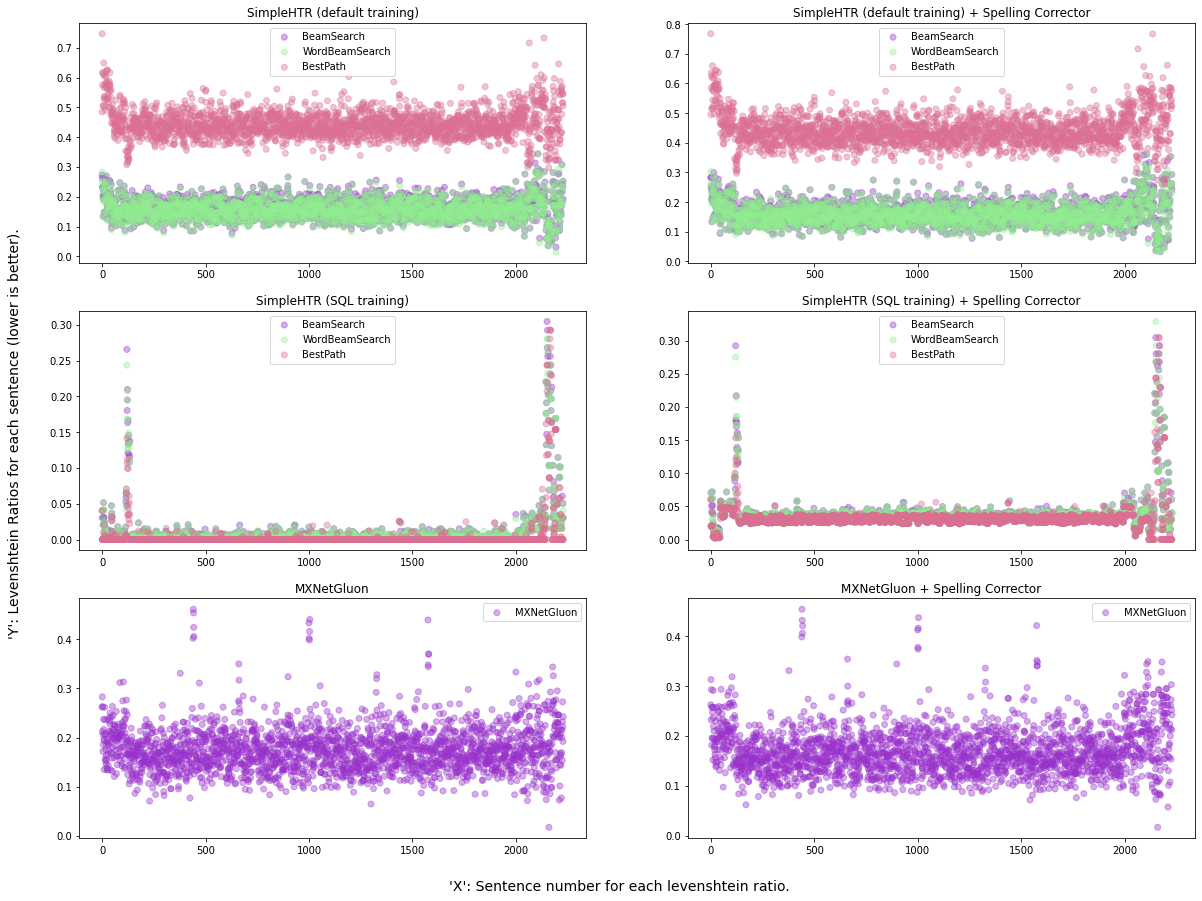

In [7]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(3,2, figsize=(20,15))

x = []
y = []
colors = []
COLS = ["darkorchid", "lightgreen", "palevioletred"]
labels = []
LABS = ["BestPath", "BeamSearch", "WordBeamSearch"]
f = 0
row = 0
col = 0
for FILE_PATH in FILE_PATHS:
  with open(FILE_PATH + "levenshtein_ratio.out", "r") as FLR:
    LR = FLR.readlines()
    nElems = len(LR)
    for i in range(len(LR)):
      x.append(i)
      y.append(float(LR[i]))
      colors.append(COLS[f%3])
      labels.append(LABS[f%3])
      
  f+=1 # File changed
  if row != 2: # Except for MXNetGluon label each encoding
    ax[row,col].scatter(x, y, alpha=0.4, c=colors, label=LABS[f%3])
    x = []
    y = []
    colors = []
    labels = []
  if f == 3: # New net
    ax[row,col].legend()
    #ax[r,c].set_title(' '.join(FILE_PATH[27:].split('/')))
    x = []
    y = []
    colors = []
    labels = []
    f = 0
    col +=1
    if col == 2: # New row
      col = 0
      row +=1
  elif f == 1 and row == 2:
    ax[row,col].scatter(x, y, alpha=0.4, c=colors, label="MXNetGluon")
    ax[row,col].legend()
    #ax[r,c].set_title(' '.join(FILE_PATH[27:].split('/')))
    x = []
    y = []
    colors = []
    labels = []
    f = 0
    col +=1

ax[0,0].set_title("SimpleHTR (default training)")
ax[0,1].set_title("SimpleHTR (default training) + Spelling Corrector")
ax[1,0].set_title("SimpleHTR (SQL training)")
ax[1,1].set_title("SimpleHTR (SQL training) + Spelling Corrector")
ax[2,0].set_title("MXNetGluon")
ax[2,1].set_title("MXNetGluon + Spelling Corrector")

fig.text(0.5, 0.08, '\'X\': Sentence number for each levenshtein ratio.', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, '\'Y\': Levenshtein Ratios for each sentence (lower is better).', ha='center', va='center', rotation='vertical', fontsize=14)

plt.show()

# Analyze AVG Levenshtein Ratios for each net

In [ ]:
val_shtr_def = []
val_shtr_def_fix = []
val_shtr_sql = []
val_shtr_sql_fix = []
val_mxnet = []
val_mxnet_fix = []

for FILE_PATH in FILE_PATHS:
  with open(FILE_PATH + 'levenshtein_ratio.out', 'r') as f:
    LR = [float(i) for i in f.readlines()]
    avg = mean(LR)
    
    # net = group (bottom tag)
    # alg = colour
    # print(path_split)
    path_split = FILE_PATH.split('/')
    if path_split[-3] == "MXNetGluon":
      val_mxnet.append(avg)
    elif path_split[-4] == "MXNetGluon":
      val_mxnet_fix.append(avg)
    elif path_split[-3] == "SimpleHTR":
      val_shtr_def.append(avg)
    elif path_split[-4] == "SimpleHTR":
      val_shtr_def_fix.append(avg)
    elif path_split[-3] == "TrainSimpleHTR":
      val_shtr_sql.append(avg)
    elif path_split[-4] == "TrainSimpleHTR":
      val_shtr_sql_fix.append(avg)

In [ ]:
for v in vals:
  print(v)

[0.162108048232781, 0.15848512887821947, 0.4445209080990918]
[0.16266337713950058, 0.15939409659903317, 0.4421525574480012]
[0.008392901973883374, 0.008166550492181941, 0.004165952794052635]
[0.03746934351554459, 0.03724892020478507, 0.033176431628034644]
[0.1754779092810327]
[0.17025732375208663]


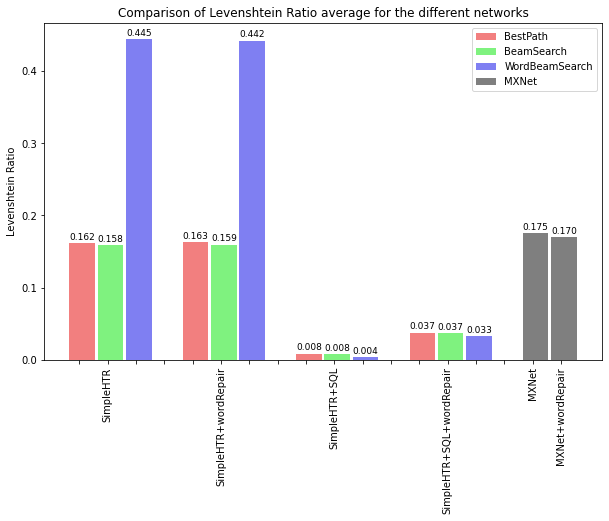

In [ ]:
# library
import matplotlib.pyplot as plt
 
# Create bars
barWidth = 0.9
bars0 = [0,0,0,0]
bars1 = [val_shtr_def[0], val_shtr_def_fix[0], val_shtr_sql[0], val_shtr_sql_fix[0]]
bars2 = [val_shtr_def[1], val_shtr_def_fix[1], val_shtr_sql[1], val_shtr_sql_fix[1]]
bars3 = [val_shtr_def[2], val_shtr_def_fix[2], val_shtr_sql[2], val_shtr_sql_fix[2]]
bars4 = val_mxnet
bars5 = val_mxnet_fix
bars6 = bars0 + bars1 + bars2 + bars3 + bars4 + bars5
 
# The X position of bars
r0 = [4,8,12,16]
r1 = [1,5,9,13]
r2 = [2,6,10,14]
r3 = [3,7,11,15]
r4 = [17]
r5 = [18]
r6 = r0 + r1 + r2 + r3 + r4 + r5
 
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = (0.9,0.0,0.0,0.5), label='BestPath')
plt.bar(r2, bars2, width = barWidth, color = (0.0,0.9,0.0,0.5), label='BeamSearch')
plt.bar(r3, bars3, width = barWidth, color = (0.0,0.0,0.9,0.5), label='WordBeamSearch')
plt.bar(r4, bars4, width = barWidth, color = (0.0,0.0,0.0,0.5), label='MXNet')
plt.bar(r5, bars5, width = barWidth, color = (0.0,0.0,0.0,0.5), label='MXNet')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend(["BestPath", "BeamSearch", "WordBeamSearch", "MXNet"])
 
# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r6))], ['','SimpleHTR','', '', '','SimpleHTR+wordRepair','', '', '','SimpleHTR+SQL','', '', '','SimpleHTR+SQL+wordRepair','', '', 'MXNet','MXNet+wordRepair'], rotation=90)
 
# Create labels
label = []
label.append(val_shtr_def)
label.append([''])
label.append(val_shtr_def_fix)
label.append([''])
label.append(val_shtr_sql)
label.append([''])
label.append(val_shtr_sql_fix)
label.append([''])
label.append(val_mxnet)
label.append(val_mxnet_fix)
label = [item for sublist in label for item in sublist]

label = ["{:.3f}".format(round(float(item),3)) if item!='' else ' ' for item in label]

# Set labels for the plot
plt.title("Comparison of Levenshtein Ratio average for the different networks")
plt.ylabel("Levenshtein Ratio")

# Text on the top of each bar
for i in range(len(r6)):
    plt.text(x = r6[i]-0.45 , y = bars6[i]+0.005, s = label[r6[i]-1], size = 9)

# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

# Mage image bigger
fig_cfg = plt.gcf()
fig_cfg.set_size_inches(10, 6, forward=True)
 
# Show graphic
plt.show()

# Represent different networks' results for a sentence


Colors:  [(0.9, 0.0, 0.0, 0.5), (0.9, 0.0, 0.0, 0.5), (0.9, 0.0, 0.0, 0.5), (0.0, 0.9, 0.0, 0.5), (0.0, 0.9, 0.0, 0.5), (0.0, 0.9, 0.0, 0.5), (0.0, 0.0, 0.9, 0.5), (0.0, 0.0, 0.9, 0.5), (0.0, 0.0, 0.9, 0.5), (0.0, 0.9, 0.9, 0.5), (0.0, 0.9, 0.9, 0.5), (0.0, 0.9, 0.9, 0.5), (0.9, 0.9, 0.0, 0.5), (0.0, 0.0, 0.0, 0.5)]
14 [0.12195121951219512, 0.11463414634146342, 0.3073170731707317, 0.1048780487804878, 0.09024390243902439, 0.3121951219512195, 0.2658536585365854, 0.24390243902439024, 0.14146341463414633, 0.2926829268292683, 0.275609756097561, 0.15365853658536585, 0.1902439024390244, 0.14146341463414633]
14 ['SimpleHTR (BestPath)', 'SimpleHTR (BeamSearch)', 'SimpleHTR (WordBeamSearch)', 'SimpleHTR (BestPath) + textRepair', 'SimpleHTR (BeamSearch) + textRepair', 'SimpleHTR (WordBeamSearch) + textRepair', 'SimpleHTR + SQL (BestPath)', 'SimpleHTR + SQL (BeamSearch)', 'SimpleHTR + SQL (WordBeamSearch)', 'SimpleHTR + SQL (BestPath) + textRepair', 'SimpleHTR + SQL (BeamSearch) + textRepair', 'Si

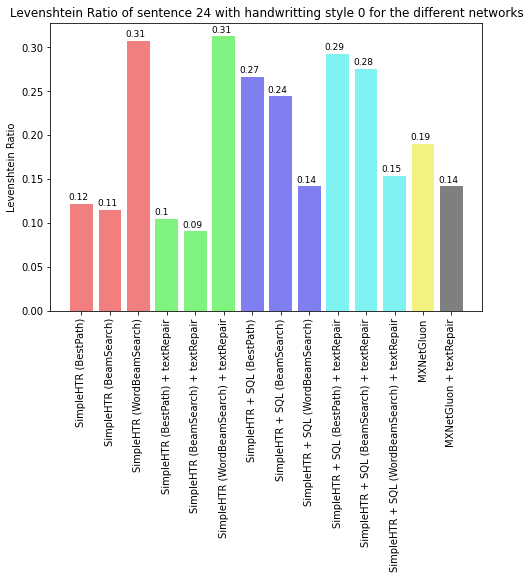

In [ ]:
import matplotlib.pyplot as plt

NUM_SENTENCE = 24
HW_STYLE = 0
prop = 5 # Number of handwriting styles per sentence

stc_vals = []
nets = []
colors = []

i = 0
for FILE_PATH in FILE_PATHS:
  i+=1
  with open(FILE_PATH + "levenshtein_ratio.out", "r") as FLR:
    LR = FLR.readlines()
    stc_vals.append(float(LR[ NUM_SENTENCE*prop + HW_STYLE ][:-1])) # Get the sentence with the respective handwriting style
    path_split = FILE_PATH.split('/')
    # print(path_split)
    if path_split[-3] == "SimpleHTR":
      nets.append(path_split[-3] + " (" + path_split[-2][4:] + ")")
      colors.append((0.9,0.0,0.0,0.5))
    elif path_split[-4] == "SimpleHTR":
      nets.append(path_split[-4] + " (" + path_split[-3][4:] + ") + textRepair")
      colors.append((0.0,0.9,0.0,0.5))
    elif path_split[-3] == "TrainSimpleHTR":
      nets.append("SimpleHTR + SQL (" + path_split[-2][4:] + ")")
      colors.append((0.0,0.0,0.9,0.5))
    elif path_split[-4] == "TrainSimpleHTR":
      nets.append("SimpleHTR + SQL (" + path_split[-3][4:] + ") + textRepair")
      colors.append((0.0,0.9,0.9,0.5))
    elif path_split[-3] == "MXNetGluon":
      nets.append(path_split[-3])
      colors.append((0.9,0.9,0.0,0.5))
    elif path_split[-4] == "MXNetGluon":
      colors.append((0.0,0.0,0.0,0.5))
      nets.append(path_split[-4] + " + textRepair")
    else:
      print(path_split)
      nets.append("Unknown")

print("Colors: ", colors)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(len(stc_vals), stc_vals)
print(len(nets), nets)
plt.title("Levenshtein Ratio of sentence " + str(NUM_SENTENCE) + " with handwritting style " + str(HW_STYLE) + " for the different networks")
plt.ylabel("Levenshtein Ratio")
ax.bar(nets, stc_vals, color=colors)

for i in range(len(stc_vals)):
    plt.text(x = i-0.45 , y = stc_vals[i]+0.005, s = round(stc_vals[i], 2), size = 9)

plt.xticks(rotation='vertical')
plt.show()